**Goal**: Try the bug detector on real bugs.

# Real bugs detected

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

## Parameters

In [2]:
ROOT_BUG_DIR = '../data/06_codeql_database/exp_v01'
PAPER_FIGURES = '../../paper-qlint/images'

## Load the data

In [4]:
df_bugs = pd.read_csv('../results_complete_dataset.csv')
# add column names
column_names = [
    'bug_name',
    'bug_description',
    'bug_type',
    'msg',
    'filepath',
    'line',
    'column',
    'end_line',
    'end_column',
]
df_bugs.columns = column_names
df_bugs.head()

,bug_name,bug_description,bug_type,msg,filepath,line,column,end_line,end_column
0,Double measurement on the same qubit.,two consecutive measurements on the same qubit...,error,repeated measurements of qubit 0 of circuit 'c...,/02_Measurements_and_Mixed_States-checkpoint_7...,4,11,4,33
1,Double measurement on the same qubit.,two consecutive measurements on the same qubit...,error,repeated measurements of qubit 0 of circuit 'c...,/02_Measurements_and_Mixed_States_d6a49c/02_Me...,6,11,6,30
2,Double measurement on the same qubit.,two consecutive measurements on the same qubit...,error,repeated measurements of qubit 0 of circuit 'q...,/03_Sequential-measurements_f46c7a/03_Sequenti...,27,6,27,25
3,Double measurement on the same qubit.,two consecutive measurements on the same qubit...,error,repeated measurements of qubit 0 of circuit 'q...,/06_Wave-function-entanglement_174d72/06_Wave-...,62,6,62,25
4,Double measurement on the same qubit.,two consecutive measurements on the same qubit...,error,repeated measurements of qubit 3 of circuit 'q...,/06_Wave-function-entanglement_174d72/06_Wave-...,134,6,134,25


## Plot the distribution of bug types

In [9]:
all_bugs = df_bugs['bug_name'].unique()
map_name_to_short = {
    'Double measurement on the same qubit.': 'Double Meas', 
    'Measure all abuse.': 'MeasureAll Abuse',
    'Operation after measurement.': 'Use after Meas', 
    'Operations after optimization.': 'Use after Opt',
    'Oversized circuit.': 'Unused Bits', 
    'Unmeasurable qubits.': 'Unmeas Qubits'
}

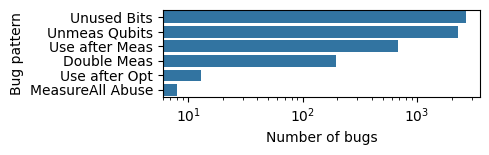

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1.65))

df = df_bugs
# replace names
df['bug_name'] = df['bug_name'].replace(map_name_to_short)

# sort by count
sns.countplot(
    y='bug_name', 
    data=df,
    color='C0',
    order=df['bug_name'].value_counts().index,
    ax=ax,
)
# log scale
ax.set_xscale('log')
ax.set_xlabel('Number of bugs')
ax.set_ylabel('Bug pattern')

# save
plt.tight_layout()
plt.savefig(f'{PAPER_FIGURES}/hist_bug_detected.pdf', bbox_inches='tight')

## Inspection of the bugs

In [22]:
CATEGORY_TO_INSPECT = 'Operation after measurement.'
CATEGORY_TO_INSPECT = 'Operations after optimization.'
df_bugs[df_bugs['bug_name'] == CATEGORY_TO_INSPECT].head()

,bug_name,bug_description,bug_type,msg,filepath,line,column,end_line,end_column
891,Operations after optimization.,Finds any operation (gate or measurement) is a...,error,Gate measure_all applied to transpiled circuit...,/Noisy%20Simulator%20Optimization_f7eeaa/Noisy...,139,1,139,30
892,Operations after optimization.,Finds any operation (gate or measurement) is a...,error,Gate measure_all applied to transpiled circuit...,/Noisy%20Simulator%20Optimization_f7eeaa/Noisy...,144,1,144,26
893,Operations after optimization.,Finds any operation (gate or measurement) is a...,error,Gate measure_all applied to transpiled circuit...,/Qiskit%20Ham%20Trotterization_1358ae/Qiskit%2...,31,1,31,24
894,Operations after optimization.,Finds any operation (gate or measurement) is a...,error,Gate measure applied to transpiled circuit: qc.,/bipartiteGraphFuncs_304480/bipartiteGraphFunc...,71,5,71,34
895,Operations after optimization.,Finds any operation (gate or measurement) is a...,error,Gate measure applied to transpiled circuit: qc.,/completeGraphFuncs_186fa2/completeGraphFuncs_...,77,5,77,34


In [25]:
def read_around_line(path, line, end_line, delta=4):
    """Read the file and return the lines around the line of interest.
    
    Delta is the number of lines to read before and after the line of interest.
    """
    all_lines = open(path).readlines()
    first_line = max(0, line - delta)
    last_line = min(len(all_lines), end_line + delta)
    return ''.join(all_lines[first_line:last_line])

for bug in df_bugs[df_bugs['bug_name'] == CATEGORY_TO_INSPECT].itertuples():
    print("-" * 80)
    print(bug.bug_name)
    print(bug.filepath)
    path = ROOT_BUG_DIR + bug.filepath
    relevant_part = read_around_line(path, bug.line, bug.end_line)
    print(relevant_part)


--------------------------------------------------------------------------------
Operations after optimization.
/Noisy%20Simulator%20Optimization_f7eeaa/Noisy%20Simulator%20Optimization_f7eeaa.py
r, initial_qc = param_FP_Grover_circuit(n, indices_to_mark, itr, d,
    noise_params_x0)
trans_qc_initial = transpile(initial_qc, sim_noise, optimization_level=0)
trans_qc_initial.measure_all()
job_initial = sim_noise.run(trans_qc_initial, shots=8192, optimization_level=0)
counts_initial = job_initial.result().get_counts()
r, opt_qc = param_FP_Grover_circuit(n, indices_to_mark, itr, d, res.x)
trans_qc_opt = transpile(opt_qc, sim_noise, optimization_level=0)

--------------------------------------------------------------------------------
Operations after optimization.
/Noisy%20Simulator%20Optimization_f7eeaa/Noisy%20Simulator%20Optimization_f7eeaa.py
counts_initial = job_initial.result().get_counts()
r, opt_qc = param_FP_Grover_circuit(n, indices_to_mark, itr, d, res.x)
trans_qc_opt = transpil

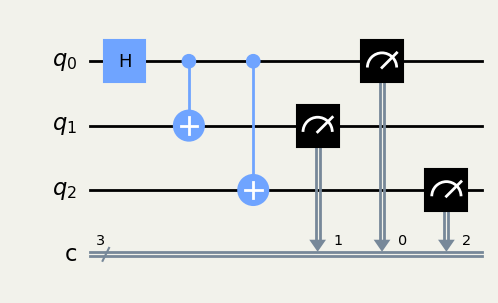

In [22]:
import matplotlib.pyplot as plt
import matplotlib

background_color = matplotlib.colors.rgb2hex((0.95, 0.95, 0.92))

style = {'backgroundcolor': background_color}

## Simple example for paper:
from qiskit import *
from qiskit import Aer
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(0, 2)
circ.measure(range(3), range(3))
# save as pdf
circ.draw('mpl', filename=f'images/example_circuit.pdf', style=style)
